In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
path = r'/content/gdrive/MyDrive/bus' # use your path
all_files = glob.glob(path + "/*.csv")
all_files.sort()

In [ ]:
li_train = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame = pd.concat(li_train, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame.shape

(10639, 46)

# Dealing with Nan Values

## Train Dataframe

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

100772

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
frame.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,...,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000,10639.000000
mean,8.231843,8.135143,8.112044,8.099473,8.125009,9984.639722,9997.879782,10013.591785,10029.786258,10047.591315,...,5.161243,5.042818,5.007267,5.019343,183.025472,183.237710,183.467807,183.705047,183.950841,9953.147758
std,2.435170,2.433365,2.433544,2.433938,2.432950,11372.751571,11397.918230,11422.152569,11448.840285,11484.281792,...,6.734321,6.708077,6.700007,6.703113,193.709473,194.036344,194.336885,194.660012,195.046340,10744.687079
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-15.000000,-15.000000,-15.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.000000,2124.000000,2124.000000,2124.000000,2124.000000,2124.000000,...,1.000000,1.000000,1.000000,1.000000,48.000000,48.000000,48.000000,48.000000,48.000000,2357.000000
50%,8.300539,8.000000,8.000000,7.991939,8.000000,5972.000000,5972.000000,5972.000000,5983.000000,5994.000000,...,6.590308,6.132278,6.009539,6.000000,122.000000,122.000000,122.000000,123.000000,123.000000,6347.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,13946.000000,13951.500000,13980.000000,14002.000000,14018.500000,...,7.000000,7.000000,7.000000,7.000000,256.000000,256.000000,256.000000,256.000000,257.000000,13998.500000
max,15.000000,15.000000,15.000000,15.000000,15.000000,87872.000000,87872.000000,87872.000000,87872.000000,87872.000000,...,32.000000,32.000000,32.000000,32.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,75533.000000


In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'DL_bitrate']

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

# With Scaling

## MinMax Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (5212, 15)
Validation set shape (2235, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2014,0.500000,0.428571,0.428571,0.285714,0.357143,0.000182,0.000046,0.000023,0.002572,0.003016,0.319149,0.319149,0.382979,0.382979,0.340426
3568,0.571429,0.500000,0.500000,0.500000,0.500000,0.391114,0.187215,0.294258,0.316153,0.248054,0.425532,0.425532,0.425532,0.425532,0.425532
2551,0.642857,0.714286,0.642857,0.714286,0.714286,0.138349,0.144324,0.135037,0.182003,0.136687,0.702128,0.680851,0.680851,0.723404,0.723404
7071,0.714286,0.714286,0.714286,0.428571,0.428571,0.022908,0.009798,0.013736,0.013611,0.005462,0.531915,0.468085,0.468085,0.510638,0.510638
575,0.540104,0.508288,0.496822,0.494919,0.506911,0.087309,0.080822,0.058415,0.045179,0.056764,0.492692,0.458019,0.451172,0.449399,0.451609


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (5212, 15, 1)
Validation set shape (2235, 15, 1)


# Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=352, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=32, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 352)               5632      
                                                                 
 dropout_3 (Dropout)         (None, 352)               0         
                                                                 
 dense_5 (Dense)             (None, 352)               124256    
                                                                 
 dropout_4 (Dropout)         (None, 352)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                11296     
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
163/163 [==============================] - 2s 5ms/step - loss: 0.0666 - mean_absolute_error: 0.0665 - val_loss: 0.0397 - val_mean_absolute_error: 0.0397
Epoch 2/500
163/163 [==============================] - 1s 3ms/step - loss: 0.0392 - mean_absolute_error: 0.0392 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383
Epoch 3/500
163/163 [==============================] - 1s 4ms/step - loss: 0.0379 - mean_absolute_error: 0.0379 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377
Epoch 4/500
163/163 [==============================] - 1s 3ms/step - loss: 0.0375 - mean_absolute_error: 0.0375 - val_loss: 0.0390 - val_mean_absolute_error: 0.0390
Epoch 5/500
163/163 [==============================] - 1s 4ms/step - loss: 0.0373 - mean_absolute_error: 0.0373 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 6/500
163/163 [==============================] - 1s 4ms/step - loss: 0.0367 - mean_absolute_error: 0.0367 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.06474934203909355
Validation rmse: 0.06519796046152654


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

Trial 254 Complete [00h 00m 43s]
val_mean_absolute_error: 0.03796384111046791

Best val_mean_absolute_error So Far: 0.03741270676255226
Total elapsed time: 00h 35m 16s


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

In [ ]:
kt_train_pred_min_max_scaled = best_model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = best_model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.0614242777727887
Validation rmse: 0.06296823193110176


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.428571,0.428571,0.642857,0.428571,0.428571,0.000000,0.000000,0.003680,0.000034,0.000038,0.489362,0.468085,0.468085,0.531915,0.531915
1,0.428571,0.428571,0.428571,0.428571,0.642857,0.000000,0.000000,0.000000,0.000000,0.003898,0.531915,0.489362,0.489362,0.468085,0.468085
2,0.571429,0.428571,0.428571,0.428571,0.428571,0.022240,0.000000,0.000000,0.000000,0.000000,0.531915,0.531915,0.489362,0.489362,0.468085
3,0.571429,0.571429,0.571429,0.428571,0.428571,0.036378,0.048473,0.020858,0.000000,0.000000,0.531915,0.531915,0.531915,0.531915,0.489362
4,0.428571,0.571429,0.428571,0.428571,0.500000,0.021088,0.032273,0.028277,0.015935,0.031637,0.489362,0.510638,0.510638,0.574468,0.531915


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = best_model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

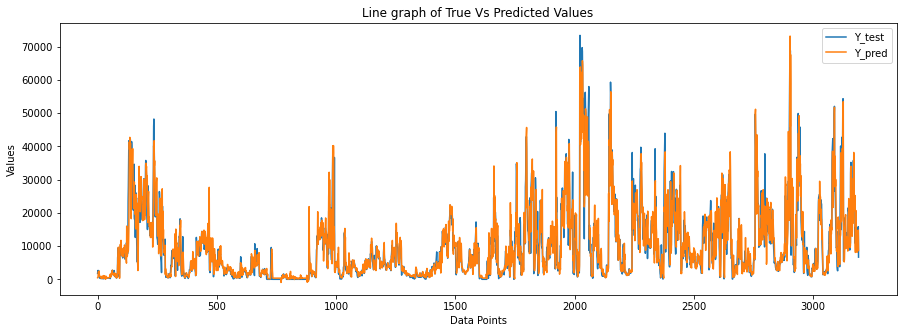

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

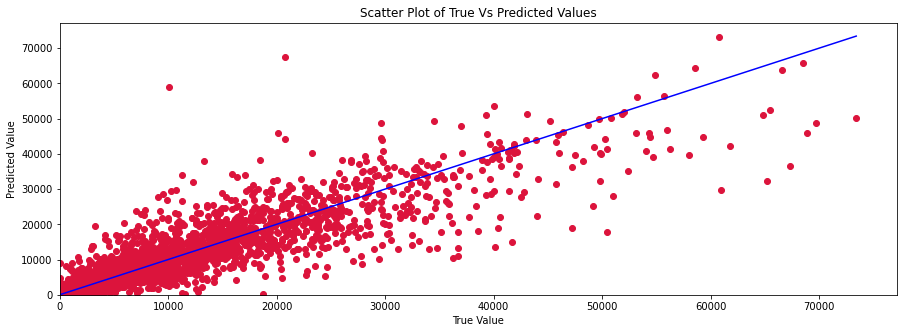

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

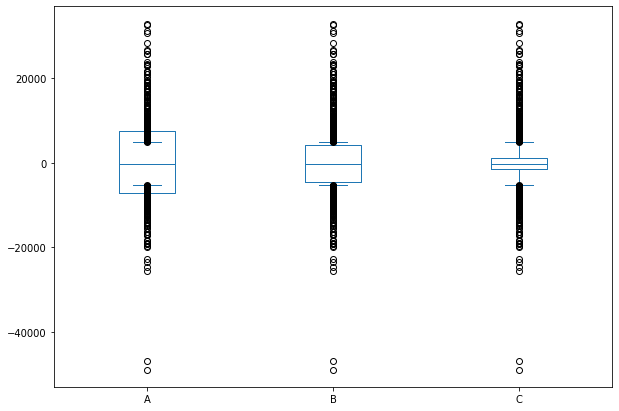

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:

# calculate MAE
error = mae(Y_test, Y_pred)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : tf.Tensor(2835.7109375, shape=(), dtype=float64)


In [ ]:
# Mean Absolute Percentage Error

error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

1.173056124063751e+17


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.3674931156817441

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.23386171549177626